# Patches Embedding

1、导入所需要的包

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

2、打开一张图片进行测试

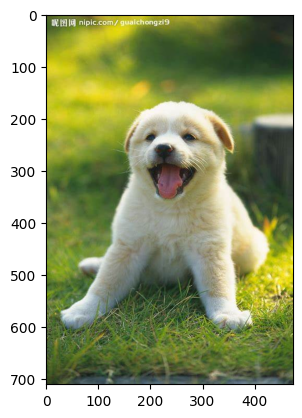

In [47]:
img = Image.open('./test.jpg')
fig = plt.figure()
plt.imshow(img)
plt.show()

3、对图片进行预处理，resize，向量化转换成size为[1、3、224、224]

In [32]:
# resize to ImageNet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)  # 主要是为了添加batch这个维度
x.shape

torch.Size([1, 3, 224, 224])

4、根据ViT的模型结构，把一张图片划分成多个patches，并铺平

In [33]:
patch_size = 16  # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
pathes.shape

torch.Size([1, 196, 768])

5、将这些patches通过一个线性映射层，这里定义了一个patchEmbedding的类，使代码更加简洁。

In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # 将原始图像切分为16*16的patch
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            # 注意这里的隐层大小设置的也是768，可以配置
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    # 这里提示函数去返回一个tensor类型的函数，当然也可以不写 ->tensor
    # def forward(self, x):
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

# 这里作者使用了Conv2d层实现相同的功能，设置卷积核和步长都为patch_size
# class PatchEmbedding(nn.Module):
#     def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
#         self.patch_size = patch_size
#         super().__init__()
#         self.projection = nn.Sequential(
#             # 使用一个卷积层而不是一个线性层 -> 性能增加
#             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
#             # 将卷积操作后的patch铺平
#             Rearrange('b e h w -> b (h w) e'),
#         )
#                 
#     def forward(self, x: Tensor) -> Tensor:
#         x = self.projection(x)
#         return x
#     
# PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

6、下一步是对映射后的patches添加上cls token以及位置编码信息。cls token是一个随机初始化的torch Parameter对象，在forward方法中它需要被拷贝b次(b是batch的数量)，然后使用torch.cat函数添加到patch前面。

In [35]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # 使用一个卷积层而不是一个线性层 -> 性能增加
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        # 生成一个维度为emb_size的向量当做cls_token
        # 使用nn.Parameter而不是普通的PyTorch张量（torch.Tensor）的好处是，它可以自动添加到模型的参数列表中，并且会在训练过程中被优化器（如 SGD 或 Adam）更新。
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape  # 单独先将batch缓存起来
        x = self.proj(x)  # 进行卷积操作
        # 将cls_token 扩展b次
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        print(cls_tokens.shape)
        print(x.shape)
        # 将cls token在维度1扩展到输入上
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 1, 768])
torch.Size([1, 196, 768])


torch.Size([1, 197, 768])

7、positional encoding
目前为止，模型还对patches在图像中的原始位置一无所知。我们需要传递给模型这些空间上的信息。可以有很多种方法来实现这个功能，在ViT中，我们让模型自己去学习这个。位置编码信息是一个形状为[N_PATCHES+1(token) * EMBED_SIZE]的张量，它直接加到映射后的patches上。

In [36]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # 使用一个卷积层而不是一个线性层 -> 性能增加
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        # 位置编码信息，一共有(img_size // patch_size)**2 + 1(cls token)个位置向量
        # 这里有个问题，到底应该添加2D还是1D的信息呢，需不要考虑图片之间的相对位置，这里的影响不会很大。
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # 将cls token在维度1扩展到输入上
        x = torch.cat([cls_tokens, x], dim=1)
        # 添加位置编码
        print(x.shape, self.positions.shape)
        # 这里运用了广播机制，把原来2维变成了3维
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])


torch.Size([1, 197, 768])

# Transformer Encoder Block

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

## 为了加快计算，我们可以使用单个矩阵一次性计算出queries,keys,values。改进后的代码如下：

In [38]:
class MultiHeadAttention_improved(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # 使用单个矩阵一次性计算出queries,keys,values
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # 将queries，keys和values划分为num_heads
        print("1qkv's shape: ", self.qkv(x).shape)  # 使用单个矩阵一次性计算出queries,keys,values
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)  # 划分到num_heads个头上
        print("2qkv's shape: ", qkv.shape)
        
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        print("queries's shape: ", queries.shape)
        print("keys's shape: ", keys.shape)
        print("values's shape: ", values.shape)
        
        # 在最后一个维度上相加
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        print("energy's shape: ", energy.shape)
        # 例如处理句子，句子的长度往往是不同的。为了能够将这些变长序列放入神经网络模型（如 Transformer 架构）进行批量处理，通常会将序列填充到相同的长度。Mask 用于标记哪些位置是原始数据，哪些位置是填充的数据。
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.emb_size ** (1/2)
        print("scaling: ", scaling)
        att = F.softmax(energy, dim=-1) / scaling
        print("att1' shape: ", att.shape)
        att = self.att_drop(att)
        print("att2' shape: ", att.shape)
        
        # 在第三个维度上相加
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        print("out1's shape: ", out.shape)
        out = rearrange(out, "b h n d -> b n (h d)")
        print("out2's shape: ", out.shape)
        out = self.projection(out)
        print("out3's shape: ", out.shape)
        return out
    
patches_embedded = PatchEmbedding()(x)
print("patches_embedding's shape: ", patches_embedded.shape)
MultiHeadAttention_improved()(patches_embedded).shape


torch.Size([1, 197, 768]) torch.Size([197, 768])
patches_embedding's shape:  torch.Size([1, 197, 768])
1qkv's shape:  torch.Size([1, 197, 2304])
2qkv's shape:  torch.Size([3, 1, 8, 197, 96])
queries's shape:  torch.Size([1, 8, 197, 96])
keys's shape:  torch.Size([1, 8, 197, 96])
values's shape:  torch.Size([1, 8, 197, 96])
energy's shape:  torch.Size([1, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([1, 8, 197, 197])
att2' shape:  torch.Size([1, 8, 197, 197])
out1's shape:  torch.Size([1, 8, 197, 96])
out2's shape:  torch.Size([1, 197, 768])
out3's shape:  torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

## 定义一个残差模块

In [39]:
class ResidualAdd(nn.Module):
    # 注意这里的fn是你之后要传入的模型，可以是一个也可以是多个。
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## 定义MLP层

In [40]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

# 创建一个完整的Transformer Encoder Block

In [41]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

# Transformer Encoder

In [42]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# 用torchsummary来打印网络结构和参数

In [43]:
# summary可以打印网络结构和参数
from torchsummary import summary
from torchvision.models import resnet18

model = resnet18()
summary(model, input_size=[(3, 256, 256)], batch_size=2, device="cpu") 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 128, 128]           9,408
       BatchNorm2d-2          [2, 64, 128, 128]             128
              ReLU-3          [2, 64, 128, 128]               0
         MaxPool2d-4            [2, 64, 64, 64]               0
            Conv2d-5            [2, 64, 64, 64]          36,864
       BatchNorm2d-6            [2, 64, 64, 64]             128
              ReLU-7            [2, 64, 64, 64]               0
            Conv2d-8            [2, 64, 64, 64]          36,864
       BatchNorm2d-9            [2, 64, 64, 64]             128
             ReLU-10            [2, 64, 64, 64]               0
       BasicBlock-11            [2, 64, 64, 64]               0
           Conv2d-12            [2, 64, 64, 64]          36,864
      BatchNorm2d-13            [2, 64, 64, 64]             128
             ReLU-14            [2, 64,

# ViT的最后一层就是一个简单的全连接层，输出分类的概率值，他对整个序列执行一个mean操作

In [44]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

# 最后将之前定义好的PatchEmbeding，TransformerEncoder，ClassificationHead整合起来

In [45]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

## 用torchsummary函数来计算参数量

In [46]:
model = ViT()
summary(model, input_size=[(3, 224, 224)], batch_size=1, device="cpu")

torch.Size([2, 197, 768]) torch.Size([197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 768, 14, 14]         590,592
         Rearrange-2              [1, 196, 768]               0
    PatchEmbedding-3              [1, 197, 768]               0
         LayerNorm-4              [1, 197, 768]           1,536
            Linear-5              [1, 197, 768]         590,592
            Linear-6              [1, 197, 768]         590,592
            Linear-7              [1, 197, 768]         590,592
           Dropout-8           [1, 8, 197, 197]               0
            Linear-9              [1, 197, 768]         590,592
MultiHeadAttention-10              [1, 197, 768]               0
          Dropout-11              [1, 197, 768]               0
      ResidualAdd-12              [1, 197, 768]               0
        LayerNorm-13              [1, 197, 768]      